In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, time
os.chdir("..")
from Source.Models.autoregGMM import AutoRegGMM
import Source.Util.preprocessing as prep
from Source.Util.util import load_params, get, get_device
import torch
from torch.utils.data import DataLoader
import torch.distributions as D
from Source.Util.simulateToyData import ToySimulator

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
runpath = "runs/set10_sphere_gauss2/"

# Load data

In [3]:
modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
params["device"]=get_device()

In [4]:
data = ToySimulator(params).data
n_gauss = params["n_gauss"]

# Initialize modified model class

In [5]:
model = AutoRegGMM(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=64, n_blocks=8, intermediate_fac=4, n_gauss=2
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1


<All keys matched successfully>

In [6]:
data_split = params["data_split"]
n_data = len(data)
cut1 = int(n_data - data_split[0])
model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)

# Generate samples

In [8]:
n_samples = 10
samples, xs, probs, probsindiv = model.sample_n_bonus(n_samples, xmin=-1.5, xmax=1.5)
samples = samples[:,1:]

print(samples)
print(np.shape(probs), np.shape(xs), np.shape(probsindiv), np.shape(samples), np.shape(data))

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


[[-0.27170187 -0.61184573  0.5844124 ]
 [ 0.8566971   0.7906741  -0.05803807]
 [ 0.46345848 -0.44471914 -0.83182126]
 [ 0.04621291 -0.4513522  -1.0911754 ]
 [-0.5354208  -0.98195374 -0.47948432]
 [ 0.0584752   0.25408086  0.9552081 ]
 [-0.8769458  -0.4403197   0.18247738]
 [-0.5668554  -0.47947615 -0.8802086 ]
 [-0.5509777  -0.55202246  0.89995086]
 [-0.74851143 -0.21301174 -0.78815496]]
(10, 3, 1000) (3, 1000) (10, 3, 2, 1000) (10, 3) (1000000, 3)


# Test plot

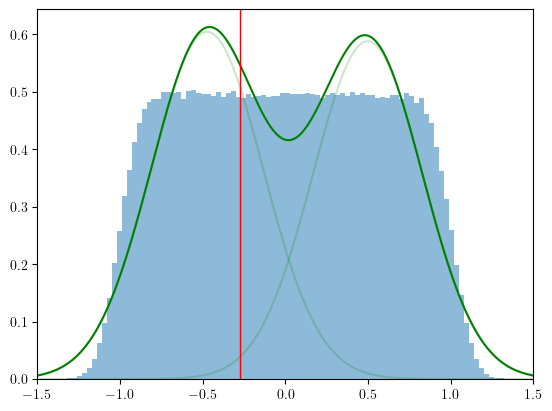

In [9]:
idim=0
isample=0
bins=100
xmin=np.min(xs[idim,:])
xmax=np.max(xs[idim,:])
plt.hist(data[:,idim], alpha=.5, bins=bins, range=(xmin, xmax), density=True, align="mid", rwidth=1.)
plt.plot(xs[idim,:], probs[isample, idim, :], color="g")
for igauss in range(n_gauss):
    plt.plot(xs[idim,:], probsindiv[isample,idim,igauss,:], color="g", linestyle="-", alpha=.2)
_, ymax = plt.ylim()
plt.vlines(samples[isample,idim], 0., ymax, "r", linewidth=1)
plt.xlim(xmin, xmax)
plt.ylim(0., ymax)
plt.show()

# Fancy plot

In [9]:
def probPlot(probs, samples, filenameOut=None, var=None, maxSamples=None, nbins=100):
    nsamples = np.shape(samples)[0]
    if(maxSamples!=None):
       nsamples = np.min([nsamples, maxSamples])
    ndim = np.shape(samples)[1]
    f, axarr = plt.subplots(nsamples, ndim, figsize=(3*ndim,3*nsamples), sharex=True,
                           gridspec_kw={"hspace": 0.})
    plt.tight_layout()
    
    ymax=np.zeros(ndim)
    for isample in range(nsamples):
        print(f"Working on sample {isample}/{nsamples}")
        for idim in range(ndim):
            xmin=xs[idim,0]
            xmax=xs[idim,-1]
            
            axarr[isample,idim].plot(xs[idim,:], probs[isample,idim,:], color="g")
            axarr[isample,idim].hist(data[:,idim], density=True, alpha=.5, range=(xmin, xmax), rwidth=1., bins=nbins, align="mid")
            for igauss in range(n_gauss):
                axarr[isample,idim].plot(xs[idim,:], probsindiv[isample,idim,igauss,:], color="g", alpha=.2)
            _, ymax0 = axarr[isample,idim].get_ylim()

            ymax[idim] = np.max([ymax[idim], ymax0])
            axarr[isample,idim].vlines(samples[isample,idim], 0., ymax[idim], color="r")
            if((type(var) is np.ndarray) and isample==nsamples-1):
                axarr[isample,idim].set_xlabel(r"${%s}$ bin" %var[idim])
    for isample in range(nsamples):
        for idim in range(ndim):
            xmin=xs[idim,0]
            xmax=xs[idim,-1]
            axarr[isample,idim].set_ylim(0, ymax[idim])
            #axarr[isample,idim].set_xlim(xmin, xmax)
    if(filenameOut!=None):
        f.savefig(filenameOut, format="pdf", bbox_inches="tight")
    #plt.close()

Working on sample 0/3
Working on sample 1/3
Working on sample 2/3


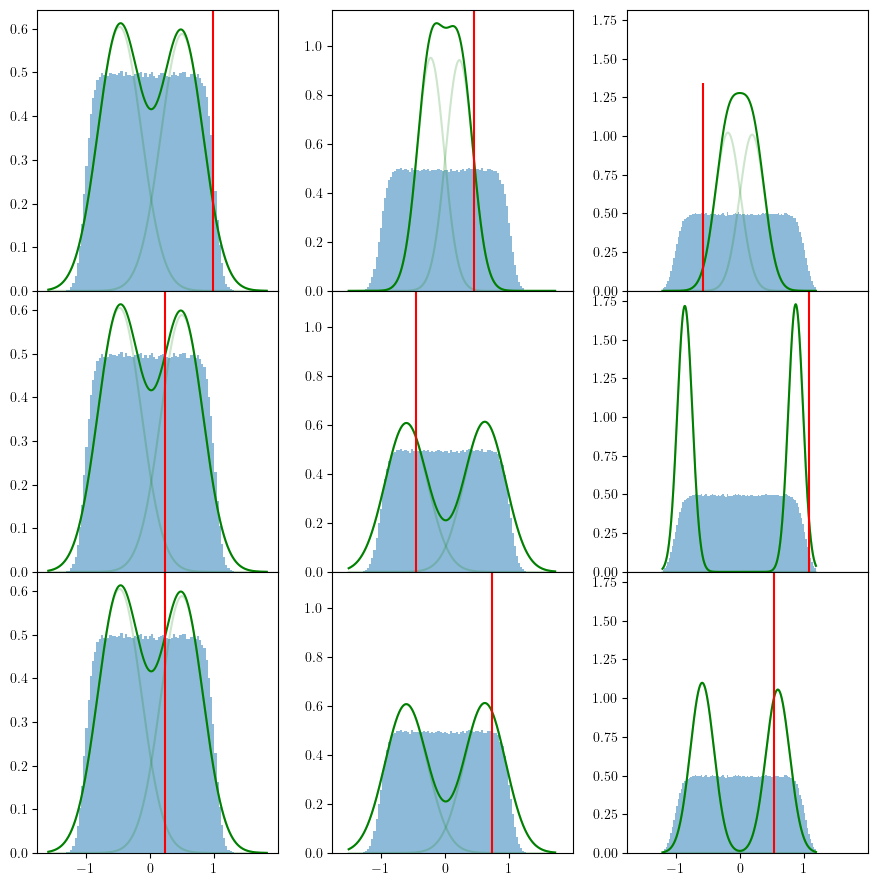

In [10]:
probPlot(probs, samples, var=None, maxSamples=3, filenameOut="test_a.pdf")

In [11]:
n_samples = 100000
samples = model.sample_n(n_samples)

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Sampling time estimate: 19.24 s = 0.32 min


# Naive likelihoods

In [12]:
def marginalize(x, likelihood, dim):
    likelihood2 = np.swapaxes(likelihood, dim, 0)
    marg = np.trapz(likelihood2, x=x, axis=0)
    return marg

In [13]:
prec = 60
xmin = -1.5
xmax = 1.5
batch_size = 4096
x0 = np.linspace(xmin, xmax, prec)
x, y, z = np.meshgrid(x0, x0, x0)
base = np.stack([x.ravel(), y.ravel(), z.ravel()], -1)
cartesianLoader = torch.utils.data.DataLoader(dataset=base, 
                                              batch_size=batch_size, 
                                              shuffle=False)
likelihood = np.zeros(0)
for batch_id, x in enumerate(cartesianLoader):
    t0 = time.time()
    x = x.float()
    _, likelihood0, _, _, _ = model.batch_loss(x, getMore=True)
    likelihood0 = likelihood0.detach().numpy()
    likelihood = np.append(likelihood, likelihood0)
    if batch_id == 0:
        t1 = time.time()
        print(f"Estimate: {(t1-t0)*(prec**3//batch_size)/60:.2f} min")
likelihoodArr = likelihood.reshape((prec, prec, prec))

Estimate: 0.37 min


In [14]:
marginalx0 = marginalize(x0, marginalize(x0, likelihoodArr, 2), 1)
marginalx1 = marginalize(x0, marginalize(x0, likelihoodArr, 2), 0)
marginalx2 = marginalize(x0, marginalize(x0, likelihoodArr, 1), 0)
norm0 = marginalize(x0, marginalx0, 0)
print(f"Check: normalization = {norm0:.10f}")
norm1 = marginalize(x0, marginalx1, 0)
print(f"Check: normalization = {norm1:.10f}")
norm2 = marginalize(x0, marginalx2, 0)
print(f"Check: normalization = {norm2:.10f}")

Check: normalization = 0.9999867521
Check: normalization = 0.9999867521
Check: normalization = 0.9999867521


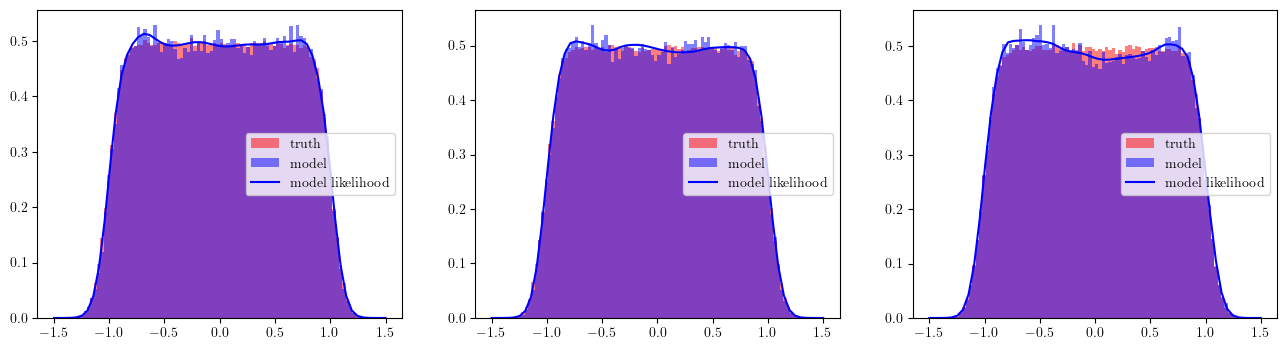

In [15]:
nbins = 100

fig=plt.figure(figsize=(16,4))
fig.add_subplot(1,3,1)
plt.hist(data[:,0], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="r", label="truth")
plt.hist(samples[:,0], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="model")
plt.plot(x0, marginalx0, label="model likelihood", color="b")
plt.legend()

fig.add_subplot(1,3,2)
plt.hist(data[:,1], density=True, range=(xmin, xmax), bins=nbins, alpha=.5, color="r", label="truth")
plt.hist(samples[:,1], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="model")
plt.plot(x0, marginalx1, label="model likelihood", color="b")
plt.legend()

fig.add_subplot(1,3,3)
plt.hist(data[:,2], density=True, range=(xmin, xmax), bins=nbins, alpha=.5, color="r", label="truth")
plt.hist(samples[:,2], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="model")
plt.plot(x0, marginalx2, label="model likelihood", color="b")
plt.legend()
plt.savefig("test3_a.pdf", bbox_inches="tight")
plt.show()

# Marginal naive likelihoods with MC integration

In [20]:
# normalization (cross-check)
N = 100000
xmin = -1.5
xmax = 1.5
batch_size = 4096
base = torch.zeros(N, 3).uniform_(xmin, xmax)
cartesianLoader = torch.utils.data.DataLoader(dataset=base, 
                                              batch_size=batch_size, 
                                              shuffle=False)
likelihood = np.zeros(0)
for batch_id, x in enumerate(cartesianLoader):
    t0 = time.time()
    x = x.float()
    _, likelihood0, _, _, _ = model.batch_loss(x, getMore=True)
    likelihood0 = likelihood0.detach().numpy()
    likelihood = np.append(likelihood, likelihood0)
    print(np.shape(likelihood0), np.shape(likelihood))
    if batch_id == 0:
        t1 = time.time()
        print(f"Estimate: {(t1-t0)*(N//batch_size)/60:.2f} min")
print(np.shape(likelihood))
V = (xmax-xmin)**3
likelihood_mean = np.mean(likelihood)
Iest = V * likelihood_mean
std = V /N**.5 * (1/(N-1) * np.sum((likelihood - likelihood_mean)**2))**.5
print(f"Result = {Iest:.4f} +/- {std:.4f}")

(4096,) (4096,)
Estimate: 0.14 min
(4096,) (8192,)
(4096,) (12288,)
(4096,) (16384,)
(4096,) (20480,)
(4096,) (24576,)
(4096,) (28672,)
(4096,) (32768,)
(4096,) (36864,)
(4096,) (40960,)
(4096,) (45056,)
(4096,) (49152,)
(4096,) (53248,)
(4096,) (57344,)
(4096,) (61440,)
(4096,) (65536,)
(4096,) (69632,)
(4096,) (73728,)
(4096,) (77824,)
(4096,) (81920,)
(4096,) (86016,)
(4096,) (90112,)
(4096,) (94208,)
(4096,) (98304,)
(1696,) (100000,)
(100000,)
Result = 1.0107 +/- 0.0071


In [23]:
#marginal1
prec = 50
N = 10000
xmin = -1.5
xmax = 1.5
batch_size = 4096
x0 = np.linspace(xmin, xmax, prec)

def getMarginalLikelihood(x0val, idim, N, out=False):
    base = torch.zeros(N, 3).uniform_(xmin, xmax)
    base[:,idim] = x0val
    cartesianLoader = torch.utils.data.DataLoader(dataset=base, 
                                              batch_size=batch_size, 
                                              shuffle=False)
    likelihood = np.zeros(0)
    for batch_id, x in enumerate(cartesianLoader):
        t0 = time.time()
        x = x.float()
        _, likelihood0, _, _, _ = model.batch_loss(x, getMore=True)
        likelihood0 = likelihood0.detach().numpy()
        likelihood = np.append(likelihood, likelihood0)
        if batch_id == 0 and out:
            t1 = time.time()
            print(f"Estimate: {(t1-t0)*(N//batch_size)/60:.2f} min")
    likelihood_mean = np.mean(likelihood)
    V = (xmax-xmin)**2
    I_mean = V * likelihood_mean
    I_variance = V /N**.5 * (1/(N-1) * np.sum((likelihood-likelihood_mean)**2))**.5
    return I_mean, I_variance
    
marg, marg_err = np.zeros((2, prec, 3))
for idim in range(3):
    for i in range(prec):
        t0 = time.time()
        print(f"{i:>3} {idim:>3}", end="\r")
        marg[i, idim], marg_err[i, idim] = getMarginalLikelihood(x0[i], idim, N)
        if idim==0 and i==0:
            t1 = time.time()
            print(f"Estimate: {(t1-t0)*(3 * prec)/60:.2f} min")

Estimate: 2.00 min


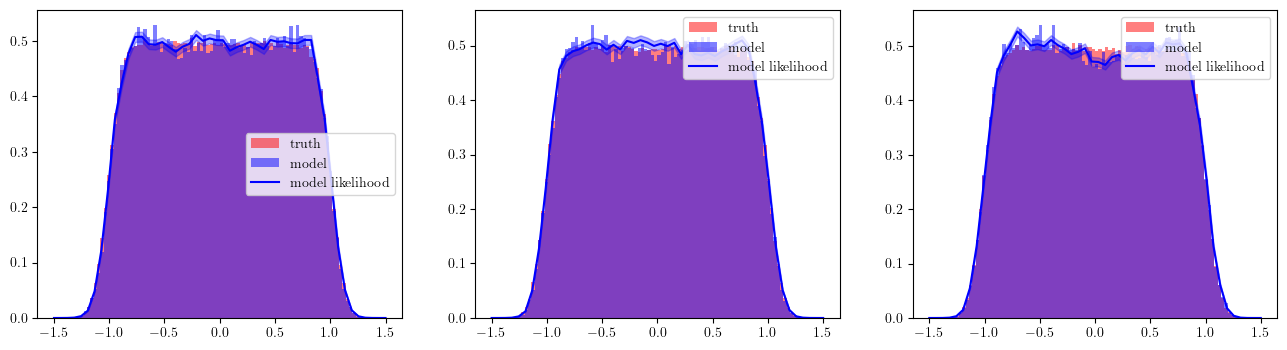

In [24]:
nbins = 100

fig=plt.figure(figsize=(16,4))
fig.add_subplot(1,3,1)
plt.hist(data[:,0], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="r", label="truth")
plt.hist(samples[:,0], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="model")
plt.plot(x0, marg[:,0], label="model likelihood", color="b")
plt.fill_between(x0, marg[:,0]+marg_err[:,0], marg[:,0]-marg_err[:,0], color="b", alpha=.3)
plt.legend()

fig.add_subplot(1,3,2)
plt.hist(data[:,1], density=True, range=(xmin, xmax), bins=nbins, alpha=.5, color="r", label="truth")
plt.hist(samples[:,1], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="model")
plt.plot(x0, marg[:,1], label="model likelihood", color="b")
plt.fill_between(x0, marg[:,1]+marg_err[:,1], marg[:,1]-marg_err[:,1], color="b", alpha=.3)
plt.legend()

fig.add_subplot(1,3,3)
plt.hist(data[:,2], density=True, range=(xmin, xmax), bins=nbins, alpha=.5, color="r", label="truth")
plt.hist(samples[:,2], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="model")
plt.plot(x0, marg[:,2], label="model likelihood", color="b")
plt.fill_between(x0, marg[:,2]+marg_err[:,2], marg[:,2]-marg_err[:,2], color="b", alpha=.3)
plt.legend()
plt.savefig("test3_ab.pdf", bbox_inches="tight")
plt.show()

# Marginal R and phi distributions

In [16]:
def getR(samples):
    return np.sum(samples**2, axis=-1)**.5
def getphi(samples, i):
    n = np.shape(samples)[1]
    if n==i+2:
        return getphiLast(samples)
    else:
        return getphiElse(samples, i)
def getphiElse(samples, i):
    return ( np.arccos(samples[:,i] / getR(samples[:,i:]) ) + 2*np.pi) % (2*np.pi)
def getphiLast(samples):
    return ( 2*np.arctan2(samples[:,-1], samples[:,-2]+getR(samples[:,-2:])) +2*np.pi) % (2*np.pi)

In [17]:
prec = 50
Rmin = 1e-2
Rmax = 2.
phimin = 0.
phimax1 = np.pi
phimax2 = 2*np.pi
batch_size=4096
R0 = np.linspace(Rmin, Rmax, prec)
phi01 = np.linspace(phimin, phimax1, prec)
phi02 = np.linspace(phimin, phimax2, prec)
R, phi1, phi2 = np.meshgrid(R0, phi01, phi02)
x1 = R*np.cos(phi1)
x2 = R*np.sin(phi1)*np.cos(phi2)
x3 = R*np.sin(phi1)*np.sin(phi2)
jacFac = R**2 * np.sin(phi1)
base = np.stack([x1.ravel(), x2.ravel(), x3.ravel(), jacFac.ravel()], -1)
sphericalLoader = torch.utils.data.DataLoader(dataset=base, 
                                              batch_size=batch_size, 
                                              shuffle=False)

likelihood = np.zeros(0)
for batch_id, x in enumerate(sphericalLoader):
    t0 = time.time()
    x0 = x[:,:3].float()
    _, likelihood0, _, _, _ = model.batch_loss(x0, getMore=True)
    likelihood0 = likelihood0.detach().numpy()
    likelihood0 = likelihood0 * x[:,3].detach().numpy()
    likelihood = np.append(likelihood, likelihood0)
    if batch_id == 0:
        t1 = time.time()
        print(f"Estimate: {(t1-t0)*(prec**3//batch_size)/60:.2f} min")
likelihoodArr = likelihood.reshape((prec, prec, prec))

Estimate: 0.17 min


In [18]:
marginalR = marginalize(phi01, marginalize(phi02, likelihoodArr, 2), 1)
marginalphi1 = marginalize(R0, marginalize(phi02, likelihoodArr, 2), 0)
marginalphi2 = marginalize(R0, marginalize(phi01, likelihoodArr, 1), 0)
norm0 = marginalize(R0, marginalR, 0)
print(f"Check: normalization = {norm0:.10f}")
norm1 = marginalize(phi01, marginalphi1, 0)
print(f"Check: normalization = {norm1:.10f}")
norm2 = marginalize(phi02, marginalphi2, 0)
print(f"Check: normalization = {norm2:.10f}")

Check: normalization = 0.9992900112
Check: normalization = 0.9992900112
Check: normalization = 0.9992900112


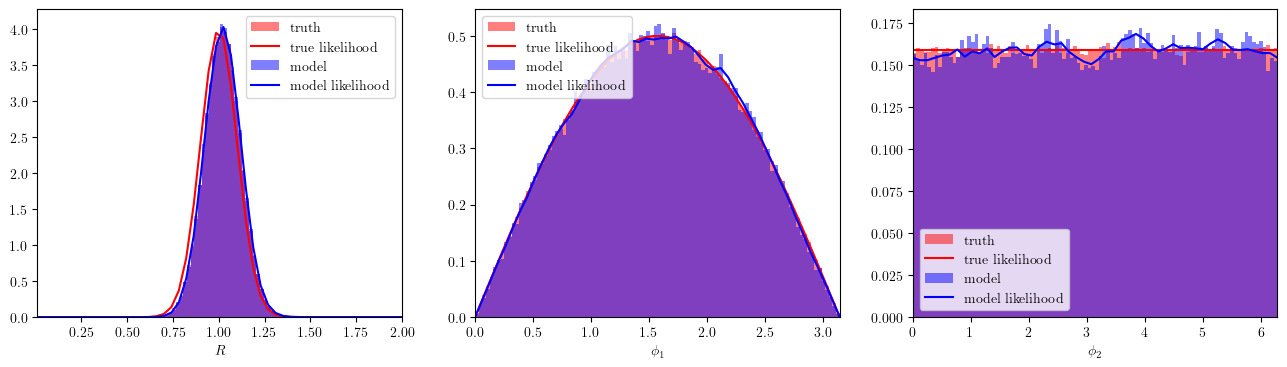

In [19]:
nbins=100
fig = plt.figure(figsize=(16,4))
fig.add_subplot(1,3,1)
plt.hist(getR(data), density=True, bins=nbins, range=(Rmin, Rmax), alpha=.5, color="r", label="truth")
plt.plot(R0, 1/(2*np.pi*.1**2)**.5 * np.exp(-(R0-1.)**2/(2*.1**2)), color="r", label="true likelihood")
plt.hist(getR(samples), density=True, bins=nbins, range=(Rmin, Rmax), alpha=.5, color="b", label="model")
plt.plot(R0, marginalR, label="model likelihood", color="b")
plt.legend()
plt.xlim(Rmin, Rmax)
plt.xlabel(r"$R$")

fig.add_subplot(1,3,2)
plt.hist(getphi(data, 0), density=True, bins=nbins, range=(phimin, phimax1), alpha=.5, color="r", label="truth")
plt.plot(phi01, .5 * np.sin(phi01), color="r", label="true likelihood")
plt.hist(getphi(samples, 0), density=True, bins=nbins, range=(phimin, phimax1), alpha=.5, color="b", label="model")
plt.plot(phi01, marginalphi1, label="model likelihood", color="b")
plt.legend()
plt.xlim(phimin, phimax1)
plt.xlabel(r"$\phi_1$")

fig.add_subplot(1,3,3)
plt.hist(getphi(data, 1), density=True, bins=nbins, range=(phimin, phimax2), alpha=.5, color="r", label="truth")
plt.plot(phi02, 1/(2*np.pi)+0*phi02, color="r", label="true likelihood")
plt.hist(getphi(samples, 1), density=True, bins=nbins, range=(phimin, phimax2), alpha=.5, color="b", label="model")
plt.plot(phi02, marginalphi2, label="model likelihood", color="b")
plt.legend()
plt.xlim(phimin, phimax2)
plt.xlabel(r"$\phi_2$")
plt.savefig("test6_a.pdf", bbox_inches="tight")
plt.show()

# Marginal R and phi distributions using MC integration

In [8]:
# normalization (cross-check)
N = 50000
Rmin = 1e-2
Rmax = 2.
phimin = 0.
phimax1 = np.pi
phimax2 = 2*np.pi
batch_size = 4096
R = torch.zeros(N).uniform_(Rmin, Rmax)
phi1 = torch.zeros(N).uniform_(phimin, phimax1)
phi2 = torch.zeros(N).uniform_(phimin, phimax2)
x1 = R * np.cos(phi1)
x2 = R * np.sin(phi1) * np.cos(phi2)
x3 = R * np.sin(phi1) * np.sin(phi2)
jacFac = R**2 * np.sin(phi1)
base = np.stack([x1, x2, x3, jacFac], -1)
cartesianLoader = torch.utils.data.DataLoader(dataset=base, 
                                              batch_size=batch_size, 
                                              shuffle=False)
likelihood = np.zeros(0)
for batch_id, x in enumerate(cartesianLoader):
    t0 = time.time()
    x0 = x[:,:3].float()
    _, likelihood0, _, _, _ = model.batch_loss(x0, getMore=True)
    likelihood0 = likelihood0 * x[:,3]
    likelihood0 = likelihood0.detach().numpy()
    likelihood = np.append(likelihood, likelihood0)
    print(np.shape(likelihood0), np.shape(likelihood))
    if batch_id == 0:
        t1 = time.time()
        print(f"Estimate: {(t1-t0)*(N//batch_size)/60:.2f} min")
V = (Rmax-Rmin) * 2*np.pi * np.pi
likelihood_mean = np.mean(likelihood)
Iest = V * likelihood_mean
Istd = V /N**.5 * (1/(N-1) * np.sum((likelihood - likelihood_mean)**2))**.5
print(f"Result = {Iest:.4f} +/- {Istd:.4f}")

(4096,) (4096,)
Estimate: 0.23 min
(4096,) (8192,)
(4096,) (12288,)
(4096,) (16384,)
(4096,) (20480,)
(4096,) (24576,)
(4096,) (28672,)
(4096,) (32768,)
(4096,) (36864,)
(4096,) (40960,)
(4096,) (45056,)
(4096,) (49152,)
(848,) (50000,)
Result = 0.9826 +/- 0.0109


In [25]:
#marginalized likelihoods
prec = 100
N = 5000
R0 = np.linspace(Rmin, Rmax, prec)

def getMarginalLikelihood(Rval, N, out=False):
    phi1 = np.random.uniform(low=phimin, high=phimax1, size=N)
    phi2 = np.random.uniform(low=phimin, high=phimax2, size=N)
    x1 = Rval * np.cos(phi1)
    x2 = Rval * np.sin(phi1) * np.cos(phi2)
    x3 = Rval * np.sin(phi1) * np.sin(phi2)
    jacFac = Rval**2 * np.sin(phi1)
    base = np.stack([x1, x2, x3, jacFac], -1)
    cartesianLoader = torch.utils.data.DataLoader(dataset=base, 
                                              batch_size=batch_size, 
                                              shuffle=False)
    likelihood = np.zeros(0)
    for batch_id, x in enumerate(cartesianLoader):
        t0 = time.time()
        x0 = x[:,:3].float()
        _, likelihood0, _, _, _ = model.batch_loss(x0, getMore=True)
        likelihood0 *= x[:,3]
        likelihood0 = likelihood0.detach().numpy()
        likelihood = np.append(likelihood, likelihood0)
        if batch_id == 0 and out:
            t1 = time.time()
            print(f"Estimate: {(t1-t0)*(N//batch_size)/60:.2f} min")
    likelihood_mean = np.mean(likelihood)
    V = 2*np.pi * np.pi
    I_mean = V * likelihood_mean
    I_variance = V /N**.5 * (1/(N-1) * np.sum((likelihood-likelihood_mean)**2))**.5
    return I_mean, I_variance
    
margR, margR_err = np.zeros((2, prec))
for i in range(prec):
    t0 = time.time()
    print(f"{i:>3}/{prec}", end="\r")
    margR[i], margR_err[i] = getMarginalLikelihood(R0[i], N)
    if i==0:
        t1 = time.time()
        print(f"Estimate: {(t1-t0)*prec/60:.2f} min")

Estimate: 0.80 min


In [26]:
prec = 100
N = 10000
phi10 = np.linspace(phimin, phimax1, prec)

def getMarginalLikelihood(phi1val, N, out=False):
    R = np.random.uniform(low=Rmin, high=Rmax, size=N)
    phi2 = np.random.uniform(low=phimin, high=phimax2, size=N)
    x1 = R * np.cos(phi1val)
    x2 = R * np.sin(phi1val) * np.cos(phi2)
    x3 = R * np.sin(phi1val) * np.sin(phi2)
    jacFac = R**2 * np.sin(phi1val)
    base = np.stack([x1, x2, x3, jacFac], -1)
    cartesianLoader = torch.utils.data.DataLoader(dataset=base, 
                                              batch_size=batch_size, 
                                              shuffle=False)
    likelihood = np.zeros(0)
    for batch_id, x in enumerate(cartesianLoader):
        t0 = time.time()
        x0 = x[:,:3].float()
        _, likelihood0, _, _, _ = model.batch_loss(x0, getMore=True)
        likelihood0 *= x[:,3]
        likelihood0 = likelihood0.detach().numpy()
        likelihood = np.append(likelihood, likelihood0)
        if batch_id == 0 and out:
            t1 = time.time()
            print(f"Estimate: {(t1-t0)*(N//batch_size)/60:.2f} min")
    likelihood_mean = np.mean(likelihood)
    V = 2*np.pi * (Rmax-Rmin)
    I_mean = V * likelihood_mean
    I_variance = V /N**.5 * (1/(N-1) * np.sum((likelihood-likelihood_mean)**2))**.5
    return I_mean, I_variance
    
margphi1, margphi1_err = np.zeros((2, prec))
for i in range(prec):
    t0 = time.time()
    print(f"{i:>3}/{prec}", end="\r")
    margphi1[i], margphi1_err[i] = getMarginalLikelihood(phi10[i], N)
    if i==0:
        t1 = time.time()
        print(f"Estimate: {(t1-t0)*prec/60:.2f} min")

Estimate: 1.60 min


In [27]:
prec = 100
N = 10000
phi20 = np.linspace(phimin, phimax2, prec)

def getMarginalLikelihood(phi2val, N, out=False):
    R = np.random.uniform(low=Rmin, high=Rmax, size=N)
    phi1 = np.random.uniform(low=phimin, high=phimax1, size=N)
    x1 = R * np.cos(phi1)
    x2 = R * np.sin(phi1) * np.cos(phi2val)
    x3 = R * np.sin(phi1) * np.sin(phi2val)
    jacFac = R**2 * np.sin(phi1)
    base = np.stack([x1, x2, x3, jacFac], -1)
    cartesianLoader = torch.utils.data.DataLoader(dataset=base, 
                                              batch_size=batch_size, 
                                              shuffle=False)
    likelihood = np.zeros(0)
    for batch_id, x in enumerate(cartesianLoader):
        t0 = time.time()
        x0 = x[:,:3].float()
        _, likelihood0, _, _, _ = model.batch_loss(x0, getMore=True)
        likelihood0 *= x[:,3]
        likelihood0 = likelihood0.detach().numpy()
        likelihood = np.append(likelihood, likelihood0)
        if batch_id == 0 and out:
            t1 = time.time()
            print(f"Estimate: {(t1-t0)*(N//batch_size)/60:.2f} min")
    likelihood_mean = np.mean(likelihood)
    V = np.pi * (Rmax-Rmin)
    I_mean = V * likelihood_mean
    I_variance = V /N**.5 * (1/(N-1) * np.sum((likelihood-likelihood_mean)**2))**.5
    return I_mean, I_variance
    
margphi2, margphi2_err = np.zeros((2, prec))
for i in range(prec):
    t0 = time.time()
    print(f"{i:>3}/{prec}", end="\r")
    margphi2[i], margphi2_err[i] = getMarginalLikelihood(phi20[i], N)
    if i==0:
        t1 = time.time()
        print(f"Estimate: {(t1-t0)*prec/60:.2f} min")

Estimate: 1.91 min


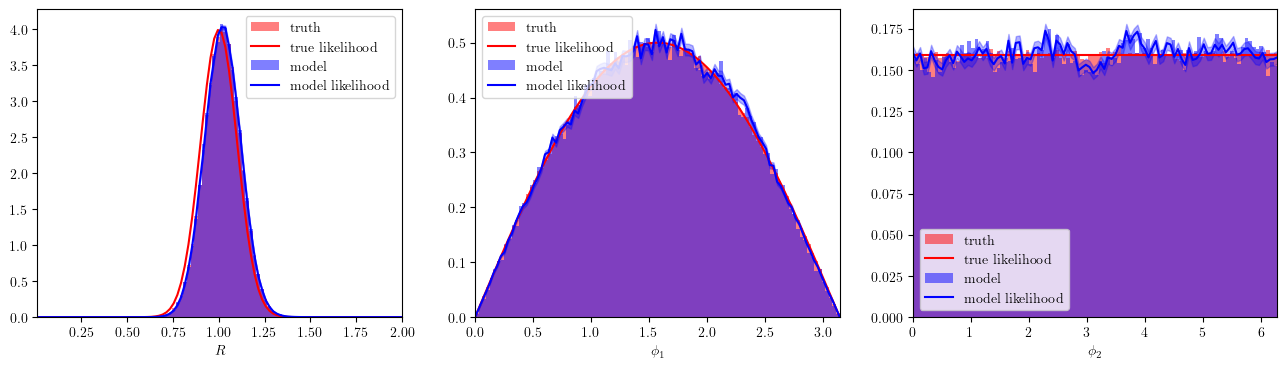

In [29]:
nbins=100
fig = plt.figure(figsize=(16,4))
fig.add_subplot(1,3,1)
plt.hist(getR(data), density=True, bins=nbins, range=(Rmin, Rmax), alpha=.5, color="r", label="truth")
plt.plot(R0, 1/(2*np.pi*.1**2)**.5 * np.exp(-(R0-1.)**2/(2*.1**2)), color="r", label="true likelihood")
plt.hist(getR(samples), density=True, bins=nbins, range=(Rmin, Rmax), alpha=.5, color="b", label="model")
plt.plot(R0, margR, label="model likelihood", color="b")
plt.fill_between(R0, margR+margR_err, margR-margR_err, color="b", alpha=.3)
plt.legend()
plt.xlim(Rmin, Rmax)
#plt.xlim(.8, 1.2)
plt.xlabel(r"$R$")

fig.add_subplot(1,3,2)
plt.hist(getphi(data, 0), density=True, bins=nbins, range=(phimin, phimax1), alpha=.5, color="r", label="truth")
plt.plot(phi10, .5 * np.sin(phi10), color="r", label="true likelihood")
plt.hist(getphi(samples, 0), density=True, bins=nbins, range=(phimin, phimax1), alpha=.5, color="b", label="model")
plt.plot(phi10, margphi1, label="model likelihood", color="b")
plt.fill_between(phi10, margphi1+margphi1_err, margphi1-margphi1_err, color="b", alpha=.3)
plt.legend()
plt.xlim(phimin, phimax1)
plt.xlabel(r"$\phi_1$")

fig.add_subplot(1,3,3)
plt.hist(getphi(data, 1), density=True, bins=nbins, range=(phimin, phimax2), alpha=.5, color="r", label="truth")
plt.plot(phi20, 1/(2*np.pi)+0*phi20, color="r", label="true likelihood")
plt.hist(getphi(samples, 1), density=True, bins=nbins, range=(phimin, phimax2), alpha=.5, color="b", label="model")
plt.plot(phi20, margphi2, label="model likelihood", color="b")
plt.fill_between(phi20, margphi2+margphi2_err, margphi2-margphi2_err, color="b", alpha=.3)
plt.legend()
plt.xlim(phimin, phimax2)
plt.xlabel(r"$\phi_2$")

plt.savefig("test6_ab.pdf", bbox_inches="tight")
plt.show()

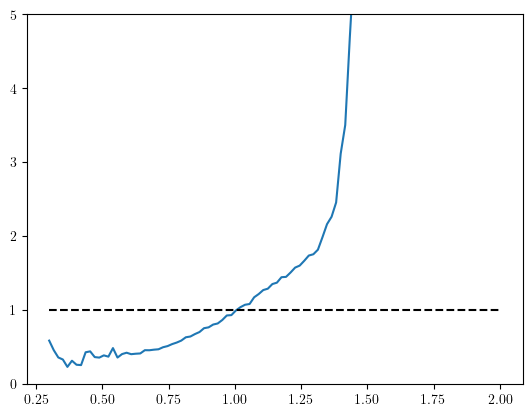

In [47]:
diff = margR / (1/(2*np.pi*.1**2)**.5 * np.exp(-(R0-1.)**2/(2*.1**2)))
plt.plot(R0, diff)
plt.plot(R0, 1+0*R0, "k--")
plt.ylim(0,5)
plt.show()

In [28]:
#marginalized likelihoods (minimal version)
prec = 50
N = 1000
xmin = -1.5
xmax = 1.5
Rmin = .3
R0 = np.linspace(Rmin, Rmax, prec)

def getMarginalLikelihood(Rval, N, out=False):
    x1 = np.random.uniform(low=xmin, high=xmax, size=N)
    x2 = np.random.uniform(low=xmin, high=xmax, size=N)
    x3 = (Rval**2 - x1**2 - x2**2)**.5
    jacFac = 2*Rval / (Rval**2 - x3**2)**.5
    x3 = np.nan_to_num(x3, nan=0.)
    jacFac = np.nan_to_num(jacFac, nan=0.)
    #TBD: Throw away nans (they kill the normalization), then keep sampling until I have N samples
    #idx = np.where(np.invert(np.isnan(x3)))
    #N = len(idx)
    #print(N)
    #x1 = x1[idx]
    #x2 = x2[idx]
    #x3 = x3[idx]
    #jacFac = jacFac[idx]
    jacFac = np.nan_to_num(jacFac, nan=0.) #these values do not contribute to integral
    base = np.stack([x1, x2, x3, jacFac], -1)
    cartesianLoader = torch.utils.data.DataLoader(dataset=base, 
                                              batch_size=batch_size, 
                                              shuffle=False)
    likelihood = np.zeros(0)
    for batch_id, x in enumerate(cartesianLoader):
        t0 = time.time()
        x0 = x[:,:3].float()
        _, likelihood0, _, _, _ = model.batch_loss(x0, getMore=True)
        likelihood0 *= x[:,3]
        likelihood0 = likelihood0.detach().numpy()
        likelihood = np.append(likelihood, likelihood0)
        if batch_id == 0 and out:
            t1 = time.time()
            print(f"Estimate: {(t1-t0)*(N//batch_size)/60:.2f} min")
    likelihood_mean = np.mean(likelihood)
    V = 2*np.pi * np.pi
    I_mean = V * likelihood_mean
    I_variance = V /N**.5 * (1/(N-1) * np.sum((likelihood-likelihood_mean)**2))**.5
    return I_mean, I_variance
    
marg, marg_err = np.zeros((2, prec))
for i in range(prec):
    t0 = time.time()
    print(f"{i:>3}/{prec}", end="\r")
    marg[i], marg_err[i] = getMarginalLikelihood(R0[i], N)
    if i==0:
        t1 = time.time()
        print(f"Estimate: {(t1-t0)*prec/60:.2f} min")

/tmp/ipykernel_2753/1788440304.py:12: RuntimeWarning: invalid value encountered in sqrt
  x3 = (Rval**2 - x1**2 - x2**2)**.5


Estimate: 0.28 min


In [80]:
#marginalized likelihoods (minimal version)
prec = 100
N = 5000
Ntry = 10 * N
xmin = -1.5
xmax = 1.5
Rmin = .6
Rmax = 1.4
R0 = np.linspace(Rmin, Rmax, prec)

def getMarginalLikelihood(Rval, N, out=False):
    Nact = 0
    base = np.zeros((0, 4))
    accRate = np.zeros(0)
    while Nact<N:
        x1 = np.random.uniform(low=xmin, high=xmax, size=Ntry)
        x2 = np.random.uniform(low=xmin, high=xmax, size=Ntry)
        x3 = (Rval**2 - x1**2 - x2**2)**.5
        jacFac = 2 * Rval / x3
        idx = np.where(np.invert(np.isnan(x3)))
        x1, x2, x3, jacFac = x1[idx], x2[idx], x3[idx], jacFac[idx]
        base = np.append(base, np.stack([x1, x2, x3, jacFac], -1), axis=0)
        Nact += np.shape(idx)[1]
        accRate = np.append(accRate, np.shape(idx)[1]/Ntry)
    accRate = np.mean(accRate)
    base = base[:N, :]
    cartesianLoader = torch.utils.data.DataLoader(dataset=base, 
                                              batch_size=batch_size, 
                                              shuffle=False)
    likelihood = np.zeros(0)
    for batch_id, x in enumerate(cartesianLoader):
        t0 = time.time()
        x0 = x[:,:3].float()
        _, likelihood0, _, _, _ = model.batch_loss(x0, getMore=True)
        likelihood0 *= x[:,3]
        likelihood0 = likelihood0.detach().numpy()
        likelihood = np.append(likelihood, likelihood0)
        if batch_id == 0 and out:
            t1 = time.time()
            print(f"Estimate: {(t1-t0)*(N//batch_size):.2f} s = {(t1-t0)*(N//batch_size)/60:.2f} min")
    likelihood_mean = np.mean(likelihood)
    V = (xmax-xmin)**2 * accRate
    I_mean = V * likelihood_mean
    I_variance = V /N**.5 * (1/(N-1) * np.sum((likelihood-likelihood_mean)**2))**.5
    return I_mean, I_variance
    
marg, marg_err = np.zeros((2, prec))
for i in range(prec):
    t0 = time.time()
    print(f"{i:>3}/{prec}", end="\r")
    marg[i], marg_err[i] = getMarginalLikelihood(R0[i], N)
    if i==0:
        t1 = time.time()
        print(f"Estimate: {(t1-t0)*prec:.2f} s = {(t1-t0)*prec/60:.2f} min")

/tmp/ipykernel_4571/2785859049.py:18: RuntimeWarning: invalid value encountered in sqrt
  x3 = (Rval**2 - x1**2 - x2**2)**.5


Estimate: 118.14 s = 1.97 min


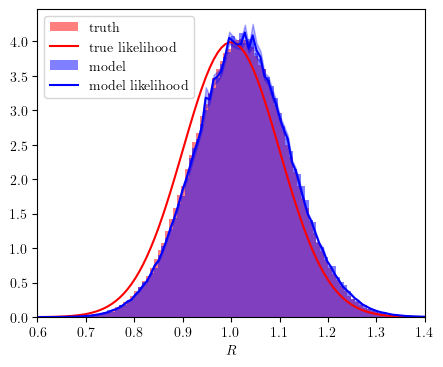

In [81]:
nbins=100
fig = plt.figure(figsize=(5,4))
fig.add_subplot(1,1,1)
plt.hist(getR(data), density=True, bins=nbins, range=(Rmin, Rmax), alpha=.5, color="r", label="truth")
plt.plot(R0, 1/(2*np.pi*.1**2)**.5 * np.exp(-(R0-1.)**2/(2*.1**2)), color="r", label="true likelihood")
plt.hist(getR(samples), density=True, bins=nbins, range=(Rmin, Rmax), alpha=.5, color="b", label="model")
plt.plot(R0, marg, label="model likelihood", color="b")
plt.fill_between(R0, marg+marg_err, marg-marg_err, color="b", alpha=.3)
plt.legend()
plt.xlim(Rmin, Rmax)
plt.xlabel(r"$R$")

plt.savefig("test6_ab.pdf", bbox_inches="tight")
plt.show()

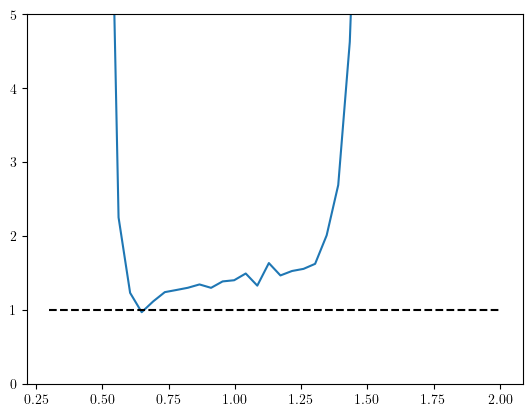

In [68]:
diff = marg / (1/(2*np.pi*.1**2)**.5 * np.exp(-(R0-1.)**2/(2*.1**2)))
plt.plot(R0, diff)
plt.plot(R0, 1+0*R0, "k--")
plt.ylim(0,5)
plt.show()

# Funny plot

In [16]:
n_samples = 100000
samples = model.sample_n(n_samples)
#samples = samples[:,1:]

Sampling time estimate: 48.72 s = 0.81 min


In [29]:
def getR(samples):
    return np.sum(samples**2, axis=-1)**.5
def getphi(samples, i):
    n = np.shape(samples)[1]
    if n==i+2:
        return getphiLast(samples)
    else:
        return getphiElse(samples, i)
def getphiElse(samples, i):
    return ( np.arccos(samples[:,i] / getR(samples[:,i:]) ) + 2*np.pi) % (2*np.pi)
def getphiLast(samples):
    return ( 2*np.arctan2(samples[:,-1], samples[:,-2]+getR(samples[:,-2:])) +2*np.pi) % (2*np.pi)

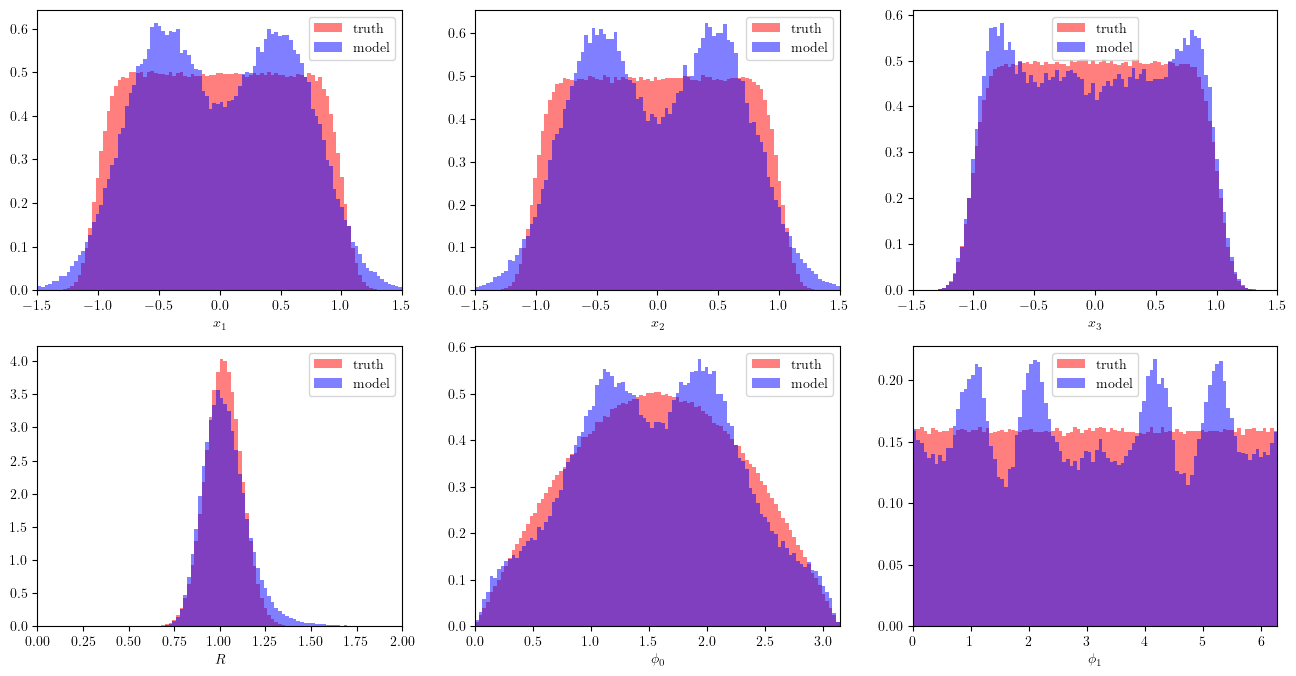

In [34]:
nbins = 100

xmin = -1.5
xmax = 1.5
fig=plt.figure(figsize=(16,8))
fig.add_subplot(2,3,1)
plt.hist(data[:,0], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="r", label="truth")
plt.hist(samples[:,0], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="model")
plt.xlim(xmin, xmax)
plt.xlabel(r"$x_1$")
plt.legend()

fig.add_subplot(2,3,2)
plt.hist(data[:,1], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="r", label="truth")
plt.hist(samples[:,1], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="model")
plt.xlim(xmin, xmax)
plt.xlabel(r"$x_2$")
plt.legend()

fig.add_subplot(2,3,3)
plt.hist(data[:,2], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="r", label="truth")
plt.hist(samples[:,2], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="model")
plt.xlim(xmin, xmax)
plt.xlabel(r"$x_3$")
plt.legend()

Rmin = 0.
Rmax = 2.
fig.add_subplot(2,3,4)
plt.hist(getR(data), density=True, range=(Rmin, Rmax), bins=nbins, alpha=.5, color="r", label="truth")
plt.hist(getR(samples), density=True, bins=nbins, range=(Rmin, Rmax), alpha=.5, color="b", label="model")
plt.xlim(Rmin, Rmax)
plt.xlabel(r"$R$")
plt.legend()

phimin = 0.
phimax = np.pi
fig.add_subplot(2,3,5)
plt.hist(getphi(data, 0), density=True, range=(phimin, phimax), bins=nbins, alpha=.5, color="r", label="truth")
plt.hist(getphi(samples, 0), density=True, bins=nbins, range=(phimin, phimax), alpha=.5, color="b", label="model")
plt.xlim(phimin, phimax)
plt.xlabel(r"$\phi_0$")
plt.legend()

phimin = 0.
phimax = 2*np.pi
fig.add_subplot(2,3,6)
plt.hist(getphi(data, 1), density=True, range=(phimin, phimax), bins=nbins, alpha=.5, color="r", label="truth")
plt.hist(getphi(samples, 1), density=True, bins=nbins, range=(phimin, phimax), alpha=.5, color="b", label="model")
plt.xlim(phimin, phimax)
plt.xlabel(r"$\phi_1$")
plt.legend()

plt.savefig("test8.pdf", bbox_inches="tight")
plt.show()

# Distinguish events by 1st gaussian

In [64]:
n_samples = 100000
n_batches = int(n_samples / model.batch_size_sample)+1
sample= np.zeros((0, model.block_size), dtype="int")
weight_idxs = np.zeros(0, dtype="int")
for i in range(n_batches):
    t0=time.time()

    idx = model.n_jets * torch.ones(model.batch_size_sample, 1, dtype=torch.int, device=model.device).float()            
    for iBlock in range(model.block_size):
        mu, sigma, weights = model.net(idx)
                
        mix = D.Categorical(weights[:,-1,:])
        weight_idx = mix.sample_n(1)[0,:]
        if iBlock==0:
            weight_idxs = np.append(weight_idxs, weight_idx.detach().cpu().numpy(), axis=0)
        
        idx_next = torch.zeros(model.batch_size_sample, 1, dtype=torch.float)
        for j in range(model.batch_size):
            comp = D.Normal(mu[j,-1,weight_idx[j]], sigma[j,-1,weight_idx[j]])
            idx_next[j] = comp.sample_n(1)

        idx = torch.cat((idx, idx_next), dim=1)
    sample = np.append(sample, idx[:,1:].detach().cpu().numpy(), axis=0)

    if(i==0): # sampling time estimate after first sampling
        t1=time.time()
        dtEst = (t1-t0)*n_batches
        print(f"Sampling time estimate: {dtEst:.2f} s = {dtEst/60:.2f} min")
                
sample = sample[:n_samples]
weight_idxs = weight_idxs[:n_samples]

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Sampling time estimate: 72.84 s = 1.21 min


In [65]:
samples = sample 

In [66]:
samples1 = samples[np.where(weight_idxs == 0)]
samples2 = samples[np.where(weight_idxs == 1)]

In [67]:
len(samples1[:,0])/len(samples[:,0])

0.48735

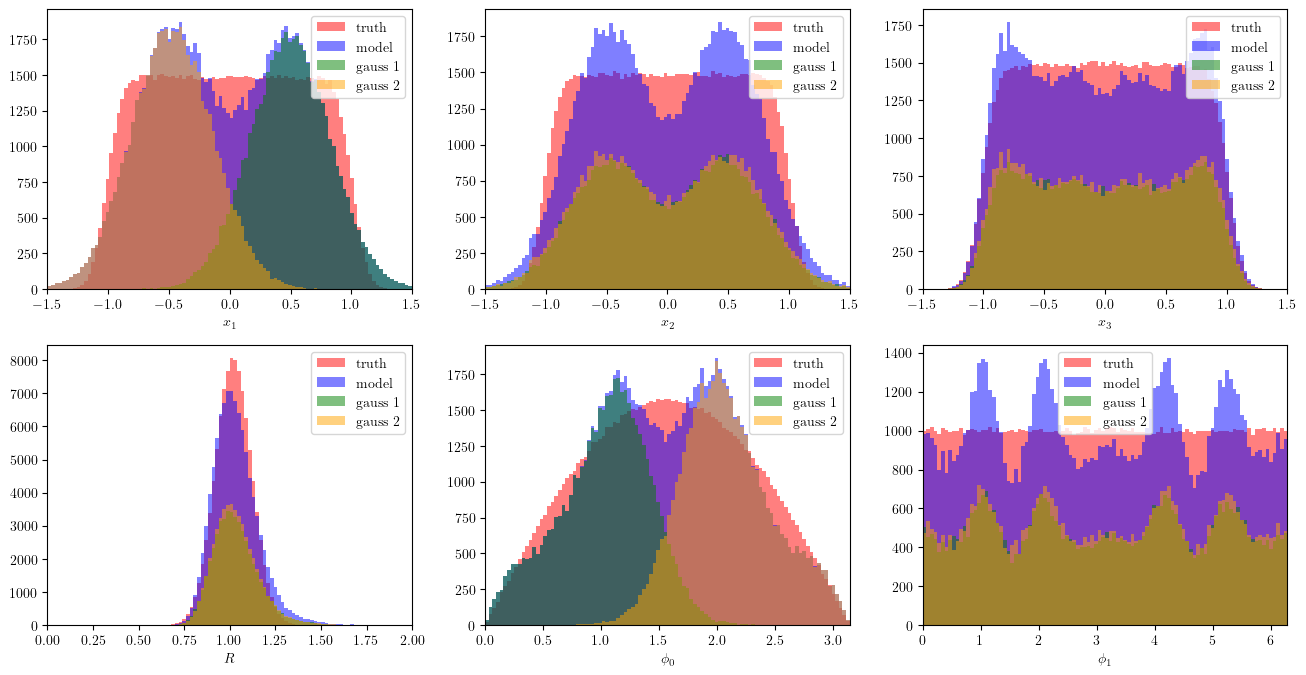

In [68]:
nbins = 100

xmin = -1.5
xmax = 1.5
fig=plt.figure(figsize=(16,8))
fig.add_subplot(2,3,1)
plt.hist(data[:,0], weights=len(samples[:,0])/len(data[:,0])*np.ones(len(data[:,0])), bins=nbins, range=(xmin, xmax), alpha=.5, color="r", label="truth")
plt.hist(samples[:,0], bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="model")
plt.hist(samples1[:,0], bins=nbins, range=(xmin, xmax), alpha=.5, color="g", label="gauss 1")
plt.hist(samples2[:,0], bins=nbins, range=(xmin, xmax), alpha=.5, color="orange", label="gauss 2")
plt.xlim(xmin, xmax)
plt.xlabel(r"$x_1$")
plt.legend()

fig.add_subplot(2,3,2)
plt.hist(data[:,1], weights=len(samples[:,1])/len(data[:,1])*np.ones(len(data[:,1])), bins=nbins, range=(xmin, xmax), alpha=.5, color="r", label="truth")
plt.hist(samples[:,1], bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="model")
plt.hist(samples1[:,1], bins=nbins, range=(xmin, xmax), alpha=.5, color="g", label="gauss 1")
plt.hist(samples2[:,1], bins=nbins, range=(xmin, xmax), alpha=.5, color="orange", label="gauss 2")
plt.xlim(xmin, xmax)
plt.xlabel(r"$x_2$")
plt.legend()

fig.add_subplot(2,3,3)
plt.hist(data[:,2], weights=len(samples[:,2])/len(data[:,2])*np.ones(len(data[:,2])), bins=nbins, range=(xmin, xmax), alpha=.5, color="r", label="truth")
plt.hist(samples[:,2], bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="model")
plt.hist(samples1[:,2], bins=nbins, range=(xmin, xmax), alpha=.5, color="g", label="gauss 1")
plt.hist(samples2[:,2], bins=nbins, range=(xmin, xmax), alpha=.5, color="orange", label="gauss 2")
plt.xlim(xmin, xmax)
plt.xlabel(r"$x_3$")
plt.legend()

Rmin = 0.
Rmax = 2.
fig.add_subplot(2,3,4)
plt.hist(getR(data), weights=len(samples[:,1])/len(data[:,1])*np.ones(len(data[:,1])), bins=nbins, range=(Rmin, Rmax), alpha=.5, color="r", label="truth")
plt.hist(getR(samples), bins=nbins, range=(Rmin, Rmax), alpha=.5, color="b", label="model")
plt.hist(getR(samples1), bins=nbins, range=(Rmin, Rmax), alpha=.5, color="g", label="gauss 1")
plt.hist(getR(samples2), bins=nbins, range=(Rmin, Rmax), alpha=.5, color="orange", label="gauss 2")
plt.xlim(Rmin, Rmax)
plt.xlabel(r"$R$")
plt.legend()

phimin = 0.
phimax = np.pi
fig.add_subplot(2,3,5)
plt.hist(getphi(data, 0), weights=len(samples[:,1])/len(data[:,1])*np.ones(len(data[:,1])), bins=nbins, range=(phimin, phimax), alpha=.5, color="r", label="truth")
plt.hist(getphi(samples, 0), bins=nbins, range=(phimin, phimax), alpha=.5, color="b", label="model")
plt.hist(getphi(samples1, 0), bins=nbins, range=(phimin, phimax), alpha=.5, color="g", label="gauss 1")
plt.hist(getphi(samples2, 0), bins=nbins, range=(phimin, phimax), alpha=.5, color="orange", label="gauss 2")
plt.xlim(phimin, phimax)
plt.xlabel(r"$\phi_0$")
plt.legend()

phimin = 0.
phimax = 2*np.pi
fig.add_subplot(2,3,6)
plt.hist(getphi(data, 1), weights=len(samples[:,1])/len(data[:,1])*np.ones(len(data[:,1])), bins=nbins, range=(phimin, phimax), alpha=.5, color="r", label="truth")
plt.hist(getphi(samples, 1), bins=nbins, range=(phimin, phimax), alpha=.5, color="b", label="model")
plt.hist(getphi(samples1, 1), bins=nbins, range=(phimin, phimax), alpha=.5, color="g", label="gauss 1")
plt.hist(getphi(samples2, 1), bins=nbins, range=(phimin, phimax), alpha=.5, color="orange", label="gauss 2")
plt.xlim(phimin, phimax)
plt.xlabel(r"$\phi_1$")
plt.legend()

plt.savefig("test8.pdf", bbox_inches="tight")
plt.show()